## Analysis of genes/CDS annotated as "hypothetical", "putative", or "unknown".

In [1]:
from Bio import SeqIO, Seq
from Bio.SeqRecord import SeqRecord
import gffutils as gff
from BCBio import GFF
import copy
from IPython.display import Markdown as md

## Load reference data (genome sequences and annotation)

#### Current working dir.

In [2]:
pwd

'/home/grotec/Repositories/sbw25_newgenome/annotate/geneious'

### Read the annotations

In [116]:
db = gff.FeatureDB("gnl_MPB_PFLU_1-20210416_.gff3.db")

In [121]:
putative_and_hypotheticals = []

In [122]:
for i,feat in enumerate(db.all_features(featuretype='gene')):
    description = feat.attributes.get('description', [])
    if any(["hypothetical" in qualifier or "putative" in qualifier or "unknown" in qualifier for qualifier in description]):
#         print(i, feat.id, description)
        putative_and_hypotheticals.append(feat)

In [123]:
md(f"Found {len(putative_and_hypotheticals)} putative/hypothetical proteins.")

Found 4523 putative/hypothetical proteins.

## Read in the genome sequence

In [39]:
new_genome_fa= "/home/grotec/mnt/wallace/home/grotec/data/sync/sbw25/ensembl_49/Pseudomonas_fluorescens_sbw25_gca_000009225.ASM922v1.dna.chromosome.Chromosome.fa"
ref_records = next(SeqIO.parse(open(ref_fasta, 'r'),'fasta'))

In [47]:
with open("putatives.txt", "w") as fp:
    for feat in putative_and_hypotheticals:
        mRNAs = db.children(feat, featuretype="mRNA")

        for mRNA in mRNAs:
            fp.write(mRNA.id.split(":")[1]+"\n")

## Processing steps
* get uniprot protein sequences
* export as fasta
* makeblastdb
* blastp

In [48]:
!wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz

--2021-05-05 15:49:46--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89966396 (86M) [application/x-gzip]
Saving to: ‘uniprot_sprot.fasta.gz’

uniprot_sprot.fasta 100%[===================>]  85.80M  1.08MB/s    in 91s     

2021-05-05 15:51:18 (963 KB/s) - ‘uniprot_sprot.fasta.gz’ saved [89966396/89966396]



In [124]:
import pandas

blastp output was written to file "putatives_blastp_out.tsv".

## Read in the blast results table.

In [137]:
blastp_data = pandas.read_csv("putatives_blastp_out.tsv", sep="\t", header=None)

In [138]:
blastp_data.head()

0                     1                     2   \
0  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS   
1  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS  sp|Q3K8D5|TTCA_PSEPF   
2  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS  sp|Q4ZQ35|TTCA_PSEU2   
3  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS  sp|Q48FG8|TTCA_PSE14   
4  sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS  sp|Q885Z7|TTCA_PSESM   

                     3    4   5    6    7   8    9    10    11   12       13  \
0  sp|C3JY43|TTCA_PSEFS  274   1  274  274   1  274  0.0  1470  274  100.000   
1  sp|Q3K8D5|TTCA_PSEPF  274   1  274  274   1  274  0.0  1442  274   97.080   
2  sp|Q4ZQ35|TTCA_PSEU2  274   1  274  274   1  274  0.0  1405  274   93.796   
3  sp|Q48FG8|TTCA_PSE14  274   1  274  274   1  274  0.0  1405  274   93.431   
4  sp|Q885Z7|TTCA_PSESM  274   1  274  274   1  274  0.0  1388  274   92.336   

    14  15  16  17                                                 18  
0  274   0   0   0  sp|C3JY43|TTCA_PSEFS tRNA-cytidine(32) 2-sulfu...  
1  266   8   0   0  sp|Q3K8D5|TTCA_PSEPF tRNA-cytidine(32) 2-sulfu...  
2  257  17   0   0  sp|Q4ZQ35|TTCA_PSEU2 tRNA-cytidine(32) 2-sulfu...  
3  256  18   0   0  sp|Q48FG8|TTCA_PSE14 tRNA-cytidine(32) 2-sulfu...  
4  253  21   0   0  sp|Q885Z7|TTCA_PSESM tRNA-cytidine(32) 2-sulfu...

In [287]:
# Have to set the column headers.
columns=["qseqid","qacc","sallseqid","sallacc","slen","sstart","send","qlen","qstart","qend","evalue","score","length","pident","nident","mismatch","gapopen","gaps","salltitles"]

In [140]:
blastp_data.shape

(607091, 19)

In [142]:
blastp_data.columns = columns

### Drop uninteresting columns

In [311]:
blastp_data.drop(columns=["qseqid", "sallacc", "evalue", "slen", "score", "length", "nident", "mismatch", "gapopen", "gaps"], inplace=True)

## Determine number of hits in bins of `pident` level.

In [312]:
blastp_data["pident_level"] = pandas.cut(blastp_data['pident'],bins=[0,60,90,97,100], labels=["poor (0-60)", "fair (60-90)", "good (90-97)", "excellent (97-100)"])

<AxesSubplot:title={'center':'Number of blastp hits in `pident` categories.'}, ylabel='pident_level'>

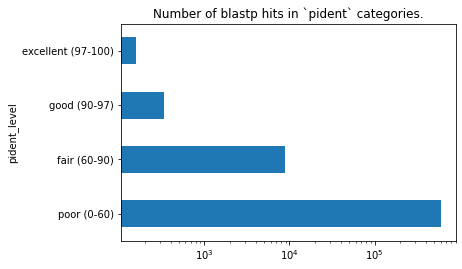

In [313]:
blastp_data.groupby("pident_level").count()['pident'].plot(kind='barh', logx=True, title="Number of blastp hits in `pident` categories.")

## Analyse only hits with pident == 100 

In [314]:
top = blastp_data[blastp_data.pident==100]

In [315]:
top

qacc             sallseqid  sstart  send  qlen  \
0         sp|C3JY43|TTCA_PSEFS  sp|C3JY43|TTCA_PSEFS       1   274   274   
500       sp|C3K839|Y879_PSEFS  sp|C3K839|Y879_PSEFS       1   285   285   
1000      sp|C3KE92|YACG_PSEFS  sp|C3KE92|YACG_PSEFS       1    66    66   
1175      sp|C3KE01|Y992_PSEFS  sp|C3KE01|Y992_PSEFS       1   259   259   
1495      sp|C3JZS5|TRPF_PSEFS  sp|C3JZS5|TRPF_PSEFS       1   210   210   
...                        ...                   ...     ...   ...   ...   
106454  tr|C3JY61|C3JY61_PSEFS   sp|P65116|IF1_PSEAE       1    72    72   
106455  tr|C3JY61|C3JY61_PSEFS   sp|Q02NB1|IF1_PSEAB       1    72    72   
106456  tr|C3JY61|C3JY61_PSEFS   sp|A6V4G7|IF1_PSEA7       1    72    72   
106457  tr|C3JY61|C3JY61_PSEFS   sp|Q48H67|IF1_PSE14       1    72    72   
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
0            1   274   100.0   
500          1   285   100.0   
1000         1    66   100.0   
1175         1   259   100.0   
1495         1   210   100.0   
...        ...   ...     ...   
106454       1    72   100.0   
106455       1    72   100.0   
106456       1    72   100.0   
106457       1    72   100.0   
130922      25    44   100.0   

                                               salltitles        pident_level  
0       sp|C3JY43|TTCA_PSEFS tRNA-cytidine(32) 2-sulfu...  excellent (97-100)  
500     sp|C3K839|Y879_PSEFS Nucleotide-binding protei...  excellent (97-100)  
1000    sp|C3KE92|YACG_PSEFS DNA gyrase inhibitor YacG...  excellent (97-100)  
1175    sp|C3KE01|Y992_PSEFS UPF0246 protein PFLU_0992...  excellent (97-100)  
1495    sp|C3JZS5|TRPF_PSEFS N-(5'-phosphoribosyl)anth...  excellent (97-100)  
...                                                   ...                 ...  
106454  sp|P65116|IF1_PSEAE Translation initiation fac...  excellent (97-100)  
106455  sp|Q02NB1|IF1_PSEAB Translation initiation fac...  excellent (97-100)  
106456  sp|A6V4G7|IF1_PSEA7 Translation initiation fac...  excellent (97-100)  
106457  sp|Q48H67|IF1_PSE14 Translation initiation fac...  excellent (97-100)  
130922  sp|P86348|ALPH_DEIAC Alkaline phosphatase (Fra...  excellent (97-100)  

[129 rows x 10 columns]

## Filter entries where query seq id != subject seq id
Here we look at hits where the query gene protein ID is **different** from the subject protein ID.

In [318]:
top = top[top.qacc != top.sallseqid]

In [319]:
top

qacc             sallseqid  sstart  send  qlen  \
5628      sp|C3K0N7|RL32_PSEFS  sp|Q3K8K7|RL32_PSEPF       1    60    60   
5630      sp|C3K0N7|RL32_PSEFS  sp|Q4KFS0|RL32_PSEF5       1    60    60   
7626      sp|C3JZN5|RL35_PSEFS  sp|Q4ZUG5|RL35_PSEU2       1    64    64   
7627      sp|C3JZN5|RL35_PSEFS  sp|P0A164|RL35_PSESY       1    64    64   
7628      sp|C3JZN5|RL35_PSEFS  sp|P0A163|RL35_PSESM       1    64    64   
7629      sp|C3JZN5|RL35_PSEFS  sp|Q3KEY0|RL35_PSEPF       1    64    64   
7631      sp|C3JZN5|RL35_PSEFS  sp|Q4KEW2|RL35_PSEF5       1    64    64   
7632      sp|C3JZN5|RL35_PSEFS  sp|Q48JS1|RL35_PSE14       1    64    64   
13061     sp|C3K6U0|Y090_PSEFS  sp|Q4KKI8|Y093_PSEF5       1    54    54   
106445  tr|C3JY61|C3JY61_PSEFS   sp|A4VLV5|IF1_PSEU5       1    72    72   
106446  tr|C3JY61|C3JY61_PSEFS   sp|Q4ZRK8|IF1_PSEU2       1    72    72   
106447  tr|C3JY61|C3JY61_PSEFS   sp|P65117|IF1_PSEPK       1    72    72   
106448  tr|C3JY61|C3JY61_PSEFS   sp|B0KLX5|IF1_PSEPG       1    72    72   
106449  tr|C3JY61|C3JY61_PSEFS   sp|Q3KA77|IF1_PSEPF       1    72    72   
106450  tr|C3JY61|C3JY61_PSEFS   sp|A5W1G9|IF1_PSEP1       1    72    72   
106451  tr|C3JY61|C3JY61_PSEFS   sp|A4XUY2|IF1_PSEMY       1    72    72   
106452  tr|C3JY61|C3JY61_PSEFS   sp|Q4K9U9|IF1_PSEF5       1    72    72   
106453  tr|C3JY61|C3JY61_PSEFS   sp|Q1IBD7|IF1_PSEE4       1    72    72   
106454  tr|C3JY61|C3JY61_PSEFS   sp|P65116|IF1_PSEAE       1    72    72   
106455  tr|C3JY61|C3JY61_PSEFS   sp|Q02NB1|IF1_PSEAB       1    72    72   
106456  tr|C3JY61|C3JY61_PSEFS   sp|A6V4G7|IF1_PSEA7       1    72    72   
106457  tr|C3JY61|C3JY61_PSEFS   sp|Q48H67|IF1_PSE14       1    72    72   
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
5628         1    60   100.0   
5630         1    60   100.0   
7626         1    64   100.0   
7627         1    64   100.0   
7628         1    64   100.0   
7629         1    64   100.0   
7631         1    64   100.0   
7632         1    64   100.0   
13061        1    54   100.0   
106445       1    72   100.0   
106446       1    72   100.0   
106447       1    72   100.0   
106448       1    72   100.0   
106449       1    72   100.0   
106450       1    72   100.0   
106451       1    72   100.0   
106452       1    72   100.0   
106453       1    72   100.0   
106454       1    72   100.0   
106455       1    72   100.0   
106456       1    72   100.0   
106457       1    72   100.0   
130922      25    44   100.0   

                                               salltitles        pident_level  
5628    sp|Q3K8K7|RL32_PSEPF 50S ribosomal protein L32...  excellent (97-100)  
5630    sp|Q4KFS0|RL32_PSEF5 50S ribosomal protein L32...  excellent (97-100)  
7626    sp|Q4ZUG5|RL35_PSEU2 50S ribosomal protein L35...  excellent (97-100)  
7627    sp|P0A164|RL35_PSESY 50S ribosomal protein L35...  excellent (97-100)  
7628    sp|P0A163|RL35_PSESM 50S ribosomal protein L35...  excellent (97-100)  
7629    sp|Q3KEY0|RL35_PSEPF 50S ribosomal protein L35...  excellent (97-100)  
7631    sp|Q4KEW2|RL35_PSEF5 50S ribosomal protein L35...  excellent (97-100)  
7632    sp|Q48JS1|RL35_PSE14 50S ribosomal protein L35...  excellent (97-100)  
13061   sp|Q4KKI8|Y093_PSEF5 UPF0391 membrane protein ...  excellent (97-100)  
106445  sp|A4VLV5|IF1_PSEU5 Translation initiation fac...  excellent (97-100)  
106446  sp|Q4ZRK8|IF1_PSEU2 Translation initiation fac...  excellent (97-100)  
106447  sp|P65117|IF1_PSEPK Translation initiation fac...  excellent (97-100)  
106448  sp|B0KLX5|IF1_PSEPG Translation initiation fac...  excellent (97-100)  
106449  sp|Q3KA77|IF1_PSEPF Translation initiation fac...  excellent (97-100)  
106450  sp|A5W1G9|IF1_PSEP1 Translation initiation fac...  excellent (97-100)  
106451  sp|A4XUY2|IF1_PSEMY Translation initiation fac...  excellent (97-100)  
106452  sp|Q4K9U9|IF1_PSEF5 Translation initiation fac...  excellent (97

In [320]:
md(f"We find {len(top)} loci for which sprot contains a 100% match with a different ID than the query.")

We find 23 loci for which sprot contains a 100% match with a different ID than the query.

## Now filter all queries from trEMBL and subject in SwissProt

We are interested in those software annotated queries (accession prefix "tr") that have a match in the reviewed section of Uniprot, i.e, SwissProt (prefix "sp").

In [321]:
tr_top = top[top.qacc.str.startswith("tr")]

In [324]:
md(f"{len(tr_top)} queries are trEMBL entries that have a 100% match in SwissProt)")

14 queries are trEMBL entries that have a 100% match in SwissProt)

In [325]:
tr_top

qacc             sallseqid  sstart  send  qlen  \
106445  tr|C3JY61|C3JY61_PSEFS   sp|A4VLV5|IF1_PSEU5       1    72    72   
106446  tr|C3JY61|C3JY61_PSEFS   sp|Q4ZRK8|IF1_PSEU2       1    72    72   
106447  tr|C3JY61|C3JY61_PSEFS   sp|P65117|IF1_PSEPK       1    72    72   
106448  tr|C3JY61|C3JY61_PSEFS   sp|B0KLX5|IF1_PSEPG       1    72    72   
106449  tr|C3JY61|C3JY61_PSEFS   sp|Q3KA77|IF1_PSEPF       1    72    72   
106450  tr|C3JY61|C3JY61_PSEFS   sp|A5W1G9|IF1_PSEP1       1    72    72   
106451  tr|C3JY61|C3JY61_PSEFS   sp|A4XUY2|IF1_PSEMY       1    72    72   
106452  tr|C3JY61|C3JY61_PSEFS   sp|Q4K9U9|IF1_PSEF5       1    72    72   
106453  tr|C3JY61|C3JY61_PSEFS   sp|Q1IBD7|IF1_PSEE4       1    72    72   
106454  tr|C3JY61|C3JY61_PSEFS   sp|P65116|IF1_PSEAE       1    72    72   
106455  tr|C3JY61|C3JY61_PSEFS   sp|Q02NB1|IF1_PSEAB       1    72    72   
106456  tr|C3JY61|C3JY61_PSEFS   sp|A6V4G7|IF1_PSEA7       1    72    72   
106457  tr|C3JY61|C3JY61_PSEFS   sp|Q48H67|IF1_PSE14       1    72    72   
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
106445       1    72   100.0   
106446       1    72   100.0   
106447       1    72   100.0   
106448       1    72   100.0   
106449       1    72   100.0   
106450       1    72   100.0   
106451       1    72   100.0   
106452       1    72   100.0   
106453       1    72   100.0   
106454       1    72   100.0   
106455       1    72   100.0   
106456       1    72   100.0   
106457       1    72   100.0   
130922      25    44   100.0   

                                               salltitles        pident_level  
106445  sp|A4VLV5|IF1_PSEU5 Translation initiation fac...  excellent (97-100)  
106446  sp|Q4ZRK8|IF1_PSEU2 Translation initiation fac...  excellent (97-100)  
106447  sp|P65117|IF1_PSEPK Translation initiation fac...  excellent (97-100)  
106448  sp|B0KLX5|IF1_PSEPG Translation initiation fac...  excellent (97-100)  
106449  sp|Q3KA77|IF1_PSEPF Translation initiation fac...  excellent (97-100)  
106450  sp|A5W1G9|IF1_PSEP1 Translation initiation fac...  excellent (97-100)  
106451  sp|A4XUY2|IF1_PSEMY Translation initiation fac...  excellent (97-100)  
106452  sp|Q4K9U9|IF1_PSEF5 Translation initiation fac...  excellent (97-100)  
106453  sp|Q1IBD7|IF1_PSEE4 Translation initiation fac...  excellent (97-100)  
106454  sp|P65116|IF1_PSEAE Translation initiation fac...  excellent (97-100)  
106455  sp|Q02NB1|IF1_PSEAB Translation initiation fac...  excellent (97-100)  
106456  sp|A6V4G7|IF1_PSEA7 Translation initiation fac...  excellent (97-100)  
106457  sp|Q48H67|IF1_PSE14 Translation initiation fac...  excellent (97-100)  
130922  sp|P86348|ALPH_DEIAC Alkaline phosphatase (Fra...  excellent (97-100)

In [326]:
md(f"Out of these 45, there are {len(tr_top.qacc.unique())} unique proteins:")

Out of these 45, there are 2 unique proteins:

In [327]:
tr_top.qacc.unique()

array(['tr|C3JY61|C3JY61_PSEFS', 'tr|C3K8K1|C3K8K1_PSEFS'], dtype=object)

## C3JY61 == PFLU_3804
https://www.uniprot.org/uniprot/C3JY61#similar_proteins

In [328]:
tr_top[tr_top.qacc.str.contains("C3JY61")]

qacc            sallseqid  sstart  send  qlen  \
106445  tr|C3JY61|C3JY61_PSEFS  sp|A4VLV5|IF1_PSEU5       1    72    72   
106446  tr|C3JY61|C3JY61_PSEFS  sp|Q4ZRK8|IF1_PSEU2       1    72    72   
106447  tr|C3JY61|C3JY61_PSEFS  sp|P65117|IF1_PSEPK       1    72    72   
106448  tr|C3JY61|C3JY61_PSEFS  sp|B0KLX5|IF1_PSEPG       1    72    72   
106449  tr|C3JY61|C3JY61_PSEFS  sp|Q3KA77|IF1_PSEPF       1    72    72   
106450  tr|C3JY61|C3JY61_PSEFS  sp|A5W1G9|IF1_PSEP1       1    72    72   
106451  tr|C3JY61|C3JY61_PSEFS  sp|A4XUY2|IF1_PSEMY       1    72    72   
106452  tr|C3JY61|C3JY61_PSEFS  sp|Q4K9U9|IF1_PSEF5       1    72    72   
106453  tr|C3JY61|C3JY61_PSEFS  sp|Q1IBD7|IF1_PSEE4       1    72    72   
106454  tr|C3JY61|C3JY61_PSEFS  sp|P65116|IF1_PSEAE       1    72    72   
106455  tr|C3JY61|C3JY61_PSEFS  sp|Q02NB1|IF1_PSEAB       1    72    72   
106456  tr|C3JY61|C3JY61_PSEFS  sp|A6V4G7|IF1_PSEA7       1    72    72   
106457  tr|C3JY61|C3JY61_PSEFS  sp|Q48H67|IF1_PSE14       1    72    72   

        qstart  qend  pident  \
106445       1    72   100.0   
106446       1    72   100.0   
106447       1    72   100.0   
106448       1    72   100.0   
106449       1    72   100.0   
106450       1    72   100.0   
106451       1    72   100.0   
106452       1    72   100.0   
106453       1    72   100.0   
106454       1    72   100.0   
106455       1    72   100.0   
106456       1    72   100.0   
106457       1    72   100.0   

                                               salltitles        pident_level  
106445  sp|A4VLV5|IF1_PSEU5 Translation initiation fac...  excellent (97-100)  
106446  sp|Q4ZRK8|IF1_PSEU2 Translation initiation fac...  excellent (97-100)  
106447  sp|P65117|IF1_PSEPK Translation initiation fac...  excellent (97-100)  
106448  sp|B0KLX5|IF1_PSEPG Translation initiation fac...  excellent (97-100)  
106449  sp|Q3KA77|IF1_PSEPF Translation initiation fac...  excellent (97-100)  
106450  sp|A5W1G9|IF1_PSEP1 Translation initiation fac...  excellent (97-100)  
106451  sp|A4XUY2|IF1_PSEMY Translation initiation fac...  excellent (97-100)  
106452  sp|Q4K9U9|IF1_PSEF5 Translation initiation fac...  excellent (97-100)  
106453  sp|Q1IBD7|IF1_PSEE4 Translation initiation fac...  excellent (97-100)  
106454  sp|P65116|IF1_PSEAE Translation initiation fac...  excellent (97-100)  
106455  sp|Q02NB1|IF1_PSEAB Translation initiation fac...  excellent (97-100)  
106456  sp|A6V4G7|IF1_PSEA7 Translation initiation fac...  excellent (97-100)  
106457  sp|Q48H67|IF1_PSE14 Translation initiation fac...  excellent (97-100)

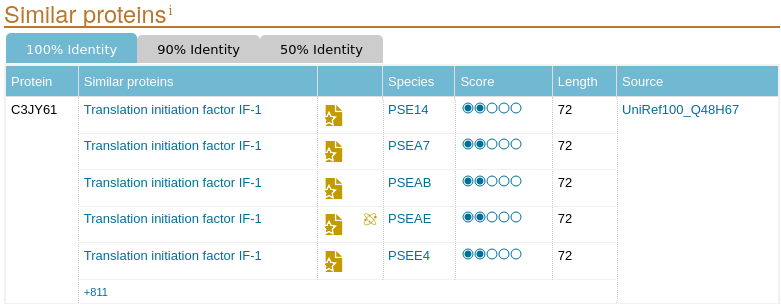

In [329]:
db["gene:PFLU_3804"].attributes.get("description")

['putative translation initiation factor IF-1']

In Pflu.SBW25, this gene product is attributed as "putative translation initiation factor IF-1" while in 100% identical homologues, it is attributed as "translation initiation factor IF-1".

## C3K8K1 == PFLU_2427
https://www.uniprot.org/uniprot/C3K8K1#similar_proteins

In [330]:
tr_top[tr_top.qacc.str.contains("C3K8K1")]

qacc             sallseqid  sstart  send  qlen  \
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
130922      25    44   100.0   

                                               salltitles        pident_level  
130922  sp|P86348|ALPH_DEIAC Alkaline phosphatase (Fra...  excellent (97-100)

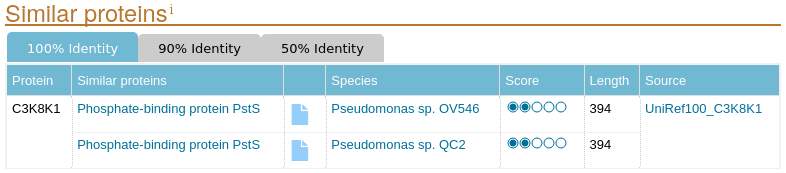

In [331]:
top[top.qacc.str.contains("C3K8K1")]

qacc             sallseqid  sstart  send  qlen  \
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
130922      25    44   100.0   

                                               salltitles        pident_level  
130922  sp|P86348|ALPH_DEIAC Alkaline phosphatase (Fra...  excellent (97-100)

In [333]:
blastp_data.loc[blastp_data.qacc.str.contains("C3K8K1")]

qacc                  sallseqid  sstart  send  qlen  \
130900  tr|C3K8K1|C3K8K1_PSEFS       sp|Q02HI0|PPBL_PSEAB       1   392   394   
130901  tr|C3K8K1|C3K8K1_PSEFS        sp|P85173|PHBP_UNKP       1   375   394   
130902  tr|C3K8K1|C3K8K1_PSEFS       sp|K4LAH1|PPBL_PSEAI       1   392   394   
130903  tr|C3K8K1|C3K8K1_PSEFS       sp|P35482|PPBL_PSEAE       1   368   394   
130904  tr|C3K8K1|C3K8K1_PSEFS       sp|B3EWG9|PARP_SACSO       1   102   394   
130905  tr|C3K8K1|C3K8K1_PSEFS       sp|B3EWG9|PARP_SACSO     102   218   394   
130906  tr|C3K8K1|C3K8K1_PSEFS      sp|Q9KK89|PSTS3_MYCAV      95   365   394   
130907  tr|C3K8K1|C3K8K1_PSEFS      sp|Q9CBE5|PSTS3_MYCLE      80   369   394   
130908  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGT9|PSTS2_MYCTU      83   370   394   
130909  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGT8|PSTS2_MYCTO      83   370   394   
130910  tr|C3K8K1|C3K8K1_PSEFS  sp|A0A0H3MBL5|PSTS2_MYCBP      83   370   394   
130911  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGT7|PSTS3_MYCTU      81   370   394   
130912  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGT6|PSTS3_MYCTO      81   370   394   
130913  tr|C3K8K1|C3K8K1_PSEFS  sp|A0A0H3MBK5|PSTS3_MYCBP      81   370   394   
130914  tr|C3K8K1|C3K8K1_PSEFS      sp|P0A5Y3|PSTS3_MYCBO      81   370   394   
130915  tr|C3K8K1|C3K8K1_PSEFS       sp|P0AG83|PSTS_SHIFL      25   345   394   
130916  tr|C3K8K1|C3K8K1_PSEFS       sp|P0AG82|PSTS_ECOLI      25   345   394   
130917  tr|C3K8K1|C3K8K1_PSEFS       sp|Q58421|PSTS_METJA     111   353   394   
130918  tr|C3K8K1|C3K8K1_PSEFS  sp|A0A0H3M950|PSTS1_MYCBP     100   360   394   
130919  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGU1|PSTS1_MYCTU     100   360   394   
130920  tr|C3K8K1|C3K8K1_PSEFS      sp|P9WGU0|PSTS1_MYCTO     100   360   394   
130921  tr|C3K8K1|C3K8K1_PSEFS      sp|P86011|CUTI2_COLGL       1    21   394   
130922  tr|C3K8K1|C3K8K1_PSEFS       sp|P86348|ALPH_DEIAC       1    20   394   
130923  tr|C3K8K1|C3K8K1_PSEFS       sp|Q9CNJ4|PSTS_PASMU       1   337   394   
130924  tr|C3K8K1|C3K8K1_PSEFS       sp|P45192|PSTS_HAEIN       9   172   394   
130925  tr|C3K8K1|C3K8K1_PSEFS      sp|P85437|CR3RP_CANAX       1    21   394   
130926  tr|C3K8K1|C3K8K1_PSEFS       sp|P46338|PSTS_BACSU     135   245   394   
130927  tr|C3K8K1|C3K8K1_PSEFS       sp|Q98FL2|PSTS_RHILO      95   256   394   
130928  tr|C3K8K1|C3K8K1_PSEFS      sp|P80775|CWP16_PHAVU       1    20   394   
130929  tr|C3K8K1|C3K8K1_PSEFS       sp|A6YPJ8|RS3A_TRIIF      45   193   394   
130930  tr|C3K8K1|C3K8K1_PSEFS       sp|P29913|NQO1_PARDE     228   336   394   
130931  tr|C3K8K1|C3K8K1_PSEFS       sp|Q7A0X7|PSTS_STAAW     109   193   394   
130932  tr|C3K8K1|C3K8K1_PSEFS       sp|Q6G9H1|PSTS_STAAS     109   193   394   
130933  tr|C3K8K1|C3K8K1_PSEFS       sp|Q7A5Q2|PSTS_STAAN     109   193   394   
130934  tr|C3K8K1|C3K8K1_PSEFS       sp|Q7A2S1|PSTS_STAAM     109   193   394   
130935  tr|C3K8K1|C3K8K1_PSEFS       sp|Q5HG31|PSTS_STAAC     109   193   394   
130936  tr|C3K8K1|C3K8K1_PSEFS       sp|Q2FYP6|PSTS_STAA8     109   193   394   
130937  tr|C3K8K1|C3K8K1_PSEFS       sp|Q2FH48|PSTS_STAA3     109   193   394   
130938  tr|C3K8K1|C3K8K1_PSEFS       sp|Q6GH18|PSTS_STAAR     109   193   394   
130939  tr|C3K8K1|C3K8K1_PSEFS       sp|Q2YXX9|PSTS_STAAB     109   193   394   
130940  tr|C3K8K1|C3K8K1_PSEFS        sp|P28037|AL1L1_RAT     310   368   394   
130941  tr|C3K8K1|C3K8K1_PSEFS       sp|A4SNB0|DADA_AERS4     126   295   394   
130942  tr|C3K8K1|C3K8K1_PSEFS       sp|Q49XJ1|PSTS_STAS1     117   192   394   
130943  tr|C3K8K1|C3K8K1_PSEFS       sp|Q5HPF2|PSTS_STAEQ     119   194   394   
130944  tr|C3K8K1|C3K8K1_PSEFS       sp|Q8CP98|PSTS_STAES     119   194   394   

        qstart  qend   pident  \
130900       1   394   72.319   
130901      25   393   76.596   
130902       1   394   71.571   
130903       1   393   44.750   
130904      25   165   63.121   
130905     227   368   56.849   
130906      78   372   28.990   
130907      51   380   27.811   
13

In [334]:
tr_top[tr_top.qacc.str.contains("C3K8K1")]

qacc             sallseqid  sstart  send  qlen  \
130922  tr|C3K8K1|C3K8K1_PSEFS  sp|P86348|ALPH_DEIAC       1    20   394   

        qstart  qend  pident  \
130922      25    44   100.0   

                                               salltitles        pident_level  
130922  sp|P86348|ALPH_DEIAC Alkaline phosphatase (Fra...  excellent (97-100)

In [335]:
db["gene:PFLU_2427"].attributes.get("description")

['putative alkaline phosphatase']

A subpart of this protein (1-20) is 100% identical to 25-44 of P86348. No matches over the entire length in the SP section. trEMBL matches, see screenshot below above.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [270]:
putatives.head()

Entry    Entry name  \
Transcript ID                         
CAY51327       C3JYN4    ZIPA_PSEFS   
CAY47103       C3K5X7  C3K5X7_PSEFS   
CAY53750       C3K1G2    YIDC_PSEFS   
CAY46998       C3KCR8  C3KCR8_PSEFS   
CAY52573       C3K2K8    YBEY_PSEFS   

                                                   Protein names  \
Transcript ID                                                      
CAY51327                              Cell division protein ZipA   
CAY47103       Cell division protein ZapE (Z ring-associated ...   
CAY53750       Membrane protein insertase YidC (Foldase YidC)...   
CAY46998                            Ribosome-binding ATPase YchF   
CAY52573                      Endoribonuclease YbeY (EC 3.1.-.-)   

                   Gene names  \
Transcript ID                   
CAY51327       zipA PFLU_4589   
CAY47103       zapE PFLU_0835   
CAY53750       yidC PFLU_6134   
CAY46998       ychF PFLU_0729   
CAY52573       ybeY PFLU_5406   

                                                        Sequence  
Transcript ID                                                     
CAY51327       MEIGLREWLIVIGIIVIAGILFDGWRRMRGGKGKLKFRLDRNLSNL...  
CAY47103       MTPLERYQADLKRPEFFHDAAQETAVRHLQRLYDDLVAASQSKPGM...  
CAY53750       MDIKRTILIVALAIVSYVMVLKWNQDYGQAALPTQNVATNQAAPAI...  
CAY46998       MGFNCGIVGLPNVGKSTLFNALTKSGIAAENFPFCTIEPNSGIVAM...  
CAY52573       MLELDLQLATEAPAPSEAQFREWCALALRQRTADSELTIRLVDEPE...

In [209]:
blastp_salltitles_split.merge(putatives, right_on="Entry", left_on=1)

0       1                                                  2   Entry  \
0    sp  C3JY43  TTCA_PSEFS tRNA-cytidine(32) 2-sulfurtransfera...  C3JY43   
1    sp  C3K839  Y879_PSEFS Nucleotide-binding protein PFLU_087...  C3K839   
2    sp  C3KE92  YACG_PSEFS DNA gyrase inhibitor YacG OS=Pseudo...  C3KE92   
3    sp  C3KE01  Y992_PSEFS UPF0246 protein PFLU_0992 OS=Pseudo...  C3KE01   
4    sp  C3JZS5  TRPF_PSEFS N-(5'-phosphoribosyl)anthranilate i...  C3JZS5   
..   ..     ...                                                ...     ...   
101  sp  C3K0D5  MINE_PSEFS Cell division topological specifici...  C3K0D5   
102  sp  C3K4H5  GCH4_PSEFS GTP cyclohydrolase FolE2 OS=Pseudom...  C3K4H5   
103  sp  C3K4R1  PLSB_PSEFS Glycerol-3-phosphate acyltransferas...  C3K4R1   
104  sp  C3JXF9  GLSA_PSEFS Glutaminase OS=Pseudomonas fluoresc...  C3JXF9   
105  sp  C3K3I7  MDCC_PSEFS Malonate decarboxylase acyl carrier...  C3K3I7   

     Entry name                                      Protein names  \
0    TTCA_PSEFS  tRNA-cytidine(32) 2-sulfurtransferase (EC 2.8....   
1    Y879_PSEFS               Nucleotide-binding protein PFLU_0879   
2    YACG_PSEFS                          DNA gyrase inhibitor YacG   
3    Y992_PSEFS                          UPF0246 protein PFLU_0992   
4    TRPF_PSEFS  N-(5'-phosphoribosyl)anthranilate isomerase (P...   
..          ...                                                ...   
101  MINE_PSEFS       Cell division topological specificity factor   
102  GCH4_PSEFS             GTP cyclohydrolase FolE2 (EC 3.5.4.16)   
103  PLSB_PSEFS  Glycerol-3-phosphate acyltransferase (GPAT) (E...   
104  GLSA_PSEFS                           Glutaminase (EC 3.5.1.2)   
105  MDCC_PSEFS  Malonate decarboxylase acyl carrier protein (M...   

          Gene names                                           Sequence  
0     ttcA PFLU_3786  MGTLTVNQNKLQKRLRRLAGEAVADFNMIEDGDKVMVCLSGGKDSY...  
1          PFLU_0879  MRLIIVSGRSGSGKSTALNVLEDNGFYCIDNLPAGLLPELAERALI...  
2     yacG PFLU_0788  MSQPLTVDCPTCGAPVEWTAANLNRPFCSDRCKLIDLGAWAAEEHK...  
3          PFLU_0992  MLMVISPAKTLDFESTPVTPRFTQPQYLDHSQELIEQLRELSPAQI...  
4     trpF PFLU_4188  MSAVRSKICGITRIEDALAAVEAGADAIGLVFYAKSPRSVNVLQAR...  
..               ...                                                ...  
101   minE PFLU_4371  MKFLDFFRANKKPSTASVAKERLQIIVAHERGQRSTPDYLPALQKE...  
102  folE2 PFLU_6088  MNALTLPDIAAQASRQALPLDWVGMCGIALPILIDGQRLTATADAG...  
103   plsB PFLU_1255  MTRSPFRRLVFGTLRRLLYLWVRSETINQSSLTLNLDRSRPVFYVL...  
104   glsA PFLU_3587  MQAMLSSILDEVRPLIGLGKVADYIPALADVPANQLGIAVYGNDGS...  
105   mdcC PFLU_5741  METLSFEFPAGQPPKGRALVGCVGSGDLEVLLEPGTPGTLTIQVQT...  

[106 rows x 8 columns]